# Algotytmy obliczania otoczki wypukłej krok po kroku

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math
from time import perf_counter
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from functools import cmp_to_key

## Wczytywanie, zapisywanie zbiorów punktów do plikow

In [2]:
def save_points(f_path, points):
    with open(f_path, "w") as f:
        f.write(f'{points}')

def load_points(f_path):
    with open(f_path, "r") as f:
        return eval(f.readlines()[0])

## Funkcje wyznacznika, orientacji oraz odległości

In [3]:
def det(a, b, c):
    return ((b[0] - a[0]) * (c[1] - b[1]) - (b[1]-a[1]) * (c[0] - b[0]) )

def points_orientation(a, b, c, eps = 0):
    computed_det = det(a, b, c)
    if computed_det > eps: return 1 #counter-clockwise turn
    elif computed_det < -eps: return -1
    return 0

def points_distance_square(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)

## Visualizer

In [4]:
class Visualiser_embed:
    def __init__(self):
        self.v = Visualizer()
        self.ch_points = []
        self.ch_lines = []
        self.line_groups = []
        self.colors = ['blue', 'cyan', 'magenta', 'yellow', 'black']
    
    def add_ch_line(self, line):
        ch_lines.append(self.v.add_line_segments(line, color = 'red'))

    def checker_line(self, line):
        x = self.v.add_line_segment(line, color = 'green')
        self.v.remove_figure(x)

    def remove_ch_line(self):
        if len(ch_lines):
            self.v.remove_figure(ch_lines.pop())

    def add_ch_point(self, point):
        ch_points.append(self.v.add_point(point, color = 'red'))

    def remove_ch_point(self):
        if len(ch_points):
            self.v.remove_figure(ch_points.pop())
    
    def add_line(self, line, no):
        line_groups.append(self.v.add_line_segment(line, self.colors[no%len(self.colors)]))

## Algorytmy znajdowania otoczki wypukłej

Wszyskie zaimplementowane poniżej algorytmy przyjmują listę punktów w postaci [(x1, y1)...] oraz zwracają listę kolejnych punktów otoczki postaci [(x1, y1)...]


### Algorytm Grahama

Algorytm Grahama tworzy otoczkę wypukłą poprzez utrzymywanie stosu, w którym znajdują się punkty, które mogą, ale nie muszą tworzyć otoczki wypukłej. Za każdym razem jest wstawiany na stos jeden punkt z zbioru punktów i jest on usuwany ze stosu, jeżeli nie jest punktem otoczki. Kiedy algorytm kończy się, stos zawiera tylko punkty otoczki wypukłej w kierunku przeciwnym do ruchu wskazówek zegera.

Złożoność czasowa O(nlogn)

In [5]:
def graham_algorithm(points):
    lowest_y_point = points[0]
    for i in range(len(points)): 
        if points[i][1] < lowest_y_point[1] or (points[i][1] == lowest_y_point[1] and points[i][0] < lowest_y_point[0]): lowest_y_point = points[i] 

    def side_comp(x, y):
        orientation = points_orientation(lowest_y_point, x, y)
        if orientation == 0: return points_distance_square(lowest_y_point, x) - points_distance_square(lowest_y_point, y)
        return -orientation

    points.sort(key=cmp_to_key(side_comp))

    new_points = [lowest_y_point]

    for i in range(1, len(points)):
        if i == len(points)-1 or points_orientation(lowest_y_point, points[i], points[i+1]) != 0: new_points.append(points[i])

    S = [new_points[0]]
    
    for i in range(1, len(new_points)):
        while len(S) > 1 and points_orientation(S[-2], S[-1], new_points[i]) != 1: S.pop()

        S.append(new_points[i])

    return S

### Algorytm Jarvisa

Algorytm Jarvisa oblicza otoczkę wypukłą dla zbioru punktów przez technikę zwaną owijaniem paczki (gift wraping). Algorytm Jarvisa buduje sekwencję, w której każdy kolejny punkt ma najmniejszy kąt w odniesieniu do poprzedniego. Jeśli punkty mają ten sam kąt, wybieramy dalszy.

Złożoność czasowa O(nh) (gdzie h to wielkość zbioru wynikowego)

In [6]:
def jarvis_algorithm(points):
    on_chain = points[0]
    for i in range(len(points)): 
        if points[i][1] < on_chain[1] or (points[i][1] == on_chain[1] and points[i][0] < on_chain[0]): on_chain = points[i] 

    S = []
    while not S or on_chain != S[0]:
        S.append(on_chain)
        next = points[0]
        for point in points: 
            if next == on_chain or points_orientation(on_chain, next, point) == -1 or (points_orientation(on_chain, next, point) == 0 and points_distance_square(on_chain, next)< points_distance_square(on_chain, point)):
                next = point
        on_chain = next

    return S

### Algorytm Dziel i Zwyciężaj

Algorytm ten polega na rekurencyjnym podziale zbioru na dwie części, po których przeprocesowaniu następuje ich łączenie. Podział wykonujemy wedle pionowej prostej przechodzącej przez element środkowy względem wspł. x. W tym celu na początu sortujemy cały zbiór punktów. W momencie gdy zbiór zawiera jedynie <= 5 punktów, Wykonujemy brutalny algorytm wyszukiwania otoczki.

Łączenie odbywa się poprzez wybranie dla lewej otoczki punktu najbardziej wysuniętego w prawo p i dla prawej otoczki punktu najbardziej wysuniętego w lewo q. Następnie tworzymy dwa odcinki pq. Jeden z nich będziemy przesuwać w górę, a drugi w dół aż do utworzenia dolnej i górnej stycznej.

Złożoność O(nlogn)

In [7]:
# Driver code
def divide_and_conquer(points):
    points = sorted(points)
    new_points = [points[0]]
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: new_points.append(points[i])
    
    new_points.append(points[-1])

    return divide_and_conquer_main_func(new_points)

# Main function
def divide_and_conquer_main_func(points):
    if len(points) <= 5: return jarvis_algorithm(points)

    left_part = divide_and_conquer_main_func(points[:len(points)//2 + 2])
    right_part = divide_and_conquer_main_func(points[len(points)//2 + 2:])

    return merge(left_part, right_part)

# Merge function
def merge(a, b):

    if len(a) == 0: return b
    elif len(b) == 0: return a

    max_right_ind = 0
    for i in range(len(a)): 
        if a[i][0] > a[max_right_ind][0]: max_right_ind = i 

    max_left_ind = 0
    for i in range(len(b)): 
        if b[i][0] < b[max_left_ind][0]: max_left_ind = i 

    top_a_ind = bottom_a_ind = max_right_ind
    top_b_ind = bottom_b_ind = max_left_ind

 
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == -1 or (points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[top_b_ind], a[(top_a_ind + 1)%len(a)])): 
            top_a_ind = (top_a_ind + 1)%len(a)

        while len(b) > 1 and points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 1 or (points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[(top_b_ind - 1 + len(b))%len(b)], a[top_a_ind])): 
            top_b_ind = (top_b_ind - 1 + len(b))%len(b)
            done = False
            
        if done: break
        
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 1 or (points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[bottom_b_ind], a[(bottom_a_ind - 1 + len(a))%len(a)])): 
            bottom_a_ind = (bottom_a_ind - 1 + len(a))%len(a)

        while len(b) > 1 and points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == -1 or (points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[(bottom_b_ind + 1)%len(b)], a[bottom_a_ind])): 
            bottom_b_ind = (bottom_b_ind + 1)%len(b)
            done = False

        if done: break

    new_points = []
    i = top_a_ind
    while i != bottom_a_ind: 
        new_points.append(a[i])
        i = (i + 1) % len(a)
    new_points.append(a[bottom_a_ind])

    i = bottom_b_ind
    while i != top_b_ind: 
        new_points.append(b[i])
        i = (i + 1) % len(b)
    new_points.append(b[top_b_ind])

    return new_points

### Algorytm Chana

Algorytm Chana jest optymalnym względem zbioru wynikowego algorytmem znajdowania otoczki wypukłej. Oznacza to tyle, że niejako łącząc algorytm Grahama i Jarvisa łączy podejście O(nlogn) zależne od ilości danych z podejściem O(nh) zależnym od mnogości zbioru wynikowego. Polega on na stworzeniu pomiejszych otoczek podzbiorów punktów, a następnie na ich połączeniu.

Złożoność obliczeniowa O(nlogh)

In [8]:
def chan_algorithm(points):

    def most_acute(hull, a):
        left_before = points_orientation(a, hull[(len(hull) - 1) % len(hull)], hull[0])
        left_after = points_orientation(a, hull[0], hull[1% len(hull)])
        if left_before == 0 and left_after == 0: return hull[0] if points_distance_square(a, hull[0]) > points_distance_square(a, hull[1 %len(hull)]) else hull[1 % len(hull)]
        for x in range(len(hull)):
            mid_before = points_orientation(a, hull[(x + len(hull) - 1) % len(hull)], hull[x])
            mid_after = points_orientation(a, hull[x], hull[(x + 1) % len(hull)])
            if mid_after == 1 and (mid_before == 0 or mid_before == -1): 
                return hull[x]
	

    min_y_ind = 0
    for i in range(len(points)):
        if points[i][1] < points[min_y_ind][1]: min_y_ind = i

    for t in range(len(points)):
        m = min(2 ** t, len(points))
        hulls = [graham_algorithm(points[i * m:i * m +m]) for i in range((len(points)+m-1)//m)] 

        if len(hulls) == 1:  
            return hulls[0] 

        ans_hull = [] 
        on_chain = points[min_y_ind]

        # pseudo jarvis
        for i in range(m):
            ans_hull.append(on_chain)
            next = most_acute(hulls[0], on_chain)
            for j in range(1, len(hulls)):
                candidate = most_acute(hulls[j], on_chain)
                if points_orientation(on_chain, next, candidate) == -1 or (points_orientation(on_chain, next, candidate) == 0 and points_distance_square(on_chain, next) < points_distance_square(on_chain, candidate)):
                    next = candidate
                    
            on_chain = next
            if on_chain == points[min_y_ind]: return ans_hull

    return []  

### Algorytm przyrostowy

Tu opis

In [9]:
class Node:
    def __init__(self, point):
        self.point = point
        self.prev = None
        self.next = None

class DoublyLinkedList:
    def __init__(self):
        self.head = None
        self.tail = None

    def append(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.tail:
            new_node.prev = self.tail
            self.tail.next = new_node
            self.tail = new_node
        else:
            new_node.next = other.next
            new_node.prev = other
            other.next.prev = new_node
            other.next = new_node

        return new_node

    def prepend(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.head:
            new_node.next = self.head
            self.head.prev = new_node
            self.head = new_node
        else:
            new_node.next = other
            new_node.prev = other.prev
            other.prev.next = new_node
            other.prev = new_node
        
        return new_node
    
    def get_next(self, other):
        if other == self.tail: return self.head
        return other.next

    def get_prv(self, other):
        if other == self.head: return self.tail
        return other.prev

    def delete(self, other):
        if self.head == self.tail and self.head == other: 
            self.head = self.tail = None

        if other == self.head:
            self.head = self.head.next
            self.head.prev = None
        elif other == self.tail:
            self.tail = self.tail.prev
            self.tail.next = None
        else: 
            other.prev.next = other.next
            other.next.prev = other.prev
            other.next = other.prev = None

        if self.head == None or self.tail == None:
            self.head = self.tail = None

    def to_list(self):
        current = self.head
        ans = []
        while current:
            ans.append(current.point)
            current = current.next
        return ans
    
    def amend_the_hull(self, point, other):
        c1 = c2 = other
        to_be_deleted = []
        
        while points_orientation(point, c1.point, self.get_next(c1).point) == -1 or (points_orientation(point, c1.point, self.get_next(c1).point) == 0 and points_distance_square(point, c1.point) < points_distance_square(point, self.get_next(c1).point)):
            if c1 != other: to_be_deleted.append(c1)
            c1 = self.get_next(c1)

        while points_orientation(point, c2.point, self.get_prv(c2).point) == 1 or (points_orientation(point, c2.point, self.get_prv(c2).point) == 0 and points_distance_square(point, c2.point) < points_distance_square(point, self.get_prv(c2).point)):
            if c2 != other: to_be_deleted.append(c2)
            c2 = self.get_prv(c2)

        if c1 != other and c2 != other:
            to_be_deleted.append(other)
        
        for x in to_be_deleted: self.delete(x)
        return self.prepend(point, c1)

def incremental(points):
    if len(points) < 2: return points 

    points = sorted(points)

    new_points = [points[0]]
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: new_points.append(points[i])
    
    new_points.append(points[-1])
    
    CH = DoublyLinkedList()
    CH.append(new_points[0])
    added_last = CH.append(new_points[1])

    for i in range(2, len(new_points)): 
        added_last = CH.amend_the_hull(new_points[i], added_last)

        
    return CH.to_list()   

### Algorytm QuickHull

Tu opis

In [10]:
#dystans punktu p od linii, ktora laczy punkty a i b

def distanceFromLine(a,b,p):
    return abs((p[1]-a[1])*(b[0]-a[0]) - (b[1]-a[1])*(p[0]-a[0]))

def recur(a, b, p, ch, points):
    right = []
    if(len(p)==0):
        return
    #wyznaczam punkty po prawej stronie prostej ab
    for i in range(len(p)): 
        if(points_orientation(a, b, p[i]) == -1):
            right.append(p[i])

    #wyznaczam punkt najdalej lezacy od prostej ab
    if(len(right)==0):
        return 
    
    else:
        dist = -1
        for i in range(len(right)):
            if distanceFromLine(a,b,right[i]) > dist:
                index = i
                dist = distanceFromLine(a,b,right[i])

        a_ind = ch.index(a)
        new_p = right[index]
        ch.insert(a_ind+1, new_p)
        recur(a, new_p, right, ch, points)
        recur(new_p, b, right, ch, points)    
    
def Quickhull(points):
    if len(points) < 2: return points
    ch = [] 

    a = min(points)
    b = max(points)   

    ch.append(a)
    ch.append(b)
    
    recur(a,b,points,ch,points)
    recur(b,a,points,ch,points)
    
    return ch

### Algorytm Upper-Lower

Tu opis

In [11]:
   
def UpperAndLower(points):
    if len(points) < 3: return points
    sorted_points = sorted(points, key=lambda x: (x[0], x[1]))

    upper, lower = [sorted_points[0], sorted_points[1]], [sorted_points[0], sorted_points[1]]

    for idx in range(2, len(sorted_points)):
        while len(upper) > 1 and points_orientation(upper[-2], upper[-1], sorted_points[idx]) != -1:
            upper.pop()
        upper.append(sorted_points[idx])     

        while len(lower) > 1 and points_orientation(lower[-2], lower[-1], sorted_points[idx]) != 1:
            lower.pop()
        lower.append(sorted_points[idx])
    lower.reverse()
    
    upper.pop()
    lower.pop()
    
    hull = lower + upper
    
    return list(reversed(hull))


# Testy

In [12]:
def generate_uniform_points(left, right, n):
    points = [(random.uniform(left, right), random.uniform(left, right)) for _ in range(n)]
    return points

def generate_circle_points(O, R, n):
    points = [(np.cos(2*np.pi*i/n)*R+O[0], np.sin(2*np.pi*i/n)*R+O[1]) for i in range(n)]
    return points


def generate_rectangle_points(a, b, c, d, n):
    points = []
    for i in range(n):
        side = random.randint(0,3)
        if side==0:
            x = random.uniform(a[0], b[0])
            y = a[1]
        elif side==1:
            x = b[0]
            y = random.uniform(b[1], c[1])
        elif side==2:
            x = random.uniform(d[0], c[0])
            y = c[1]
        elif side==3:
            x = a[1]
            y = random.uniform(a[1], d[1])
        points.append((x,y))
    return points


def generate_square_points(a, b, c, d, axis_n, diag_n):
    points = []
    for i in range(axis_n):
        x = random.uniform(a[0], b[0])
        y = a[1]
        points.append((x, y))
    for i in range(axis_n):
        x = a[0]
        y = random.uniform(a[1], d[1])
        points.append((x, y))
    for i in range(diag_n):
        x = random.uniform(a[0], c[0])
        y = x
        points.append((x, y))
    for i in range(diag_n):
        x = random.uniform(d[0], b[0])
        y = x
        points.append((x, y))
    points.extend((a,b,c,d))
    return points

In [13]:
random_data = []

In [14]:
range_1 = generate_uniform_points(-100, 100, 50)

range_2 = generate_uniform_points(-200, 200, 100)

range_3 = generate_uniform_points(-500, 500, 500)

range_4 = generate_uniform_points(-1000, 1000, 1000)

range_5 = generate_uniform_points(-2000, 2000, 2000)

range_6 = generate_uniform_points(-4000, 4000, 4000)

range_7 = generate_uniform_points(-8000, 8000, 8000)

random_data.append((range_1, "range_1"))
random_data.append((range_2, "range_2"))
random_data.append((range_3, "range_3"))
random_data.append((range_4, "range_4"))
random_data.append((range_5, "range_5"))
random_data.append((range_6, "range_6"))
random_data.append((range_7, "range_7"))

In [15]:
circle_1 = generate_circle_points((0, 0), 10, 10)

circle_2 = generate_circle_points((0, 0), 50, 50)

circle_3 = generate_circle_points((0, 0), 100, 100)

circle_4 = generate_circle_points((0, 0), 200, 200)

circle_5 = generate_circle_points((0, 0), 250, 400)

circle_6 = generate_circle_points((0, 0), 500, 500)

circle_7 = generate_circle_points((0, 0), 1000, 1000)

random_data.append((circle_1, "circle_1"))
random_data.append((circle_2, "circle_2"))
random_data.append((circle_3, "circle_3"))
random_data.append((circle_4, "circle_4"))
random_data.append((circle_5, "circle_5"))
random_data.append((circle_6, "circle_6"))
random_data.append((circle_7, "circle_7"))

In [16]:
rectangle_1 = generate_rectangle_points((-10, -10), (10, -10), (10, 10), (-10, 10), 20)

rectangle_2 = generate_rectangle_points((-10, -10), (10, -10), (10, 10), (-10, 10), 100)

rectangle_3 = generate_rectangle_points((-20, -20), (20, -20), (20, 20), (-20, 20), 200)

rectangle_4 = generate_rectangle_points((-50, -50), (50, -50), (50, 50), (-50, 50), 500)

rectangle_5 = generate_rectangle_points((-100, -100), (100, -100), (100, 100), (-100, 100), 1000)

rectangle_6 = generate_rectangle_points((-100, -100), (100, -100), (100, 100), (-100, 100), 2500)

rectangle_7 = generate_rectangle_points((-100, -100), (100, -100), (100, 100), (-100, 100), 5000)

random_data.append((rectangle_1, "rectangle_1"))
random_data.append((rectangle_2, "rectangle_2"))
random_data.append((rectangle_3, "rectangle_3"))
random_data.append((rectangle_4, "rectangle_4"))
random_data.append((rectangle_5, "rectangle_5"))
random_data.append((rectangle_6, "rectangle_6"))
random_data.append((rectangle_7, "rectangle_7"))

In [17]:
square_1 = generate_square_points((0, 0), (10, 0), (10, 10), (0, 10), 25, 20)

square_2 = generate_square_points((0, 0), (10, 0), (10, 10), (0, 10), 50, 50)

square_3 = generate_square_points((0, 0), (20, 0), (20, 20), (0, 20), 100, 50)

square_4 = generate_square_points((0, 0), (100, 0), (100, 100), (0, 100), 250, 100)

square_5 = generate_square_points((0, 0), (500, 0), (500, 500), (0, 500), 500, 500)

square_6 = generate_square_points((0, 0), (1000, 0), (1000, 1000), (0, 1000), 1000, 500)

square_7 = generate_square_points((0, 0), (1000, 0), (1000, 1000), (0, 1000), 1000, 1000)

random_data.append((square_1, "square_1"))
random_data.append((square_2, "square_2"))
random_data.append((square_3, "square_3"))
random_data.append((square_4, "square_4"))
random_data.append((square_5, "square_5"))
random_data.append((square_6, "square_6"))
random_data.append((square_7, "square_7"))

In [18]:
def count_time(algorithm, data):
    start = perf_counter()
    algorithm(data)
    end = perf_counter()
    time = end - start
    return time

In [28]:
def time_comparison(Graham, Jarvis, DnC, Chan, Incremental, QuickHull, UpperAndLower):
    columns = ["Number of points","Type of points", "Graham", "Jarvis", "DivideAndConquer", "Chan", "Incremental", "Quickhull", "UpperAndLower"]
    data = []
    for rd, name in random_data:
        graham_time = count_time(Graham, rd)
        jarvis_time = count_time(Jarvis, rd)
        dnc_time = count_time(DnC, rd)
        chan_time = count_time(Chan, rd)
        incremental_time = count_time(Incremental, rd)
        quickhull_time = count_time(QuickHull, rd)
        upperandlower_time = count_time(UpperAndLower, rd)
        data.append((len(rd), name, graham_time, jarvis_time, dnc_time, chan_time, incremental_time, quickhull_time, upperandlower_time))
    return pd.DataFrame(data=data, columns=columns)

In [29]:
time_comparison_df = time_comparison(graham_algorithm, jarvis_algorithm, divide_and_conquer, chan_algorithm, incremental, Quickhull, UpperAndLower)
time_comparison_df

,Number of points,Type of points,Graham,Jarvis,DivideAndConquer,Chan,Incremental,Quickhull,UpperAndLower
0,50,range_1,0.000192,0.000756,0.000586,0.002814,0.000378,0.000221,0.000173
1,100,range_2,0.000339,0.001187,0.001703,0.004041,0.000654,0.000345,0.000362
2,500,range_3,0.001752,0.014272,0.005303,0.031317,0.005418,0.002082,0.001864
3,1000,range_4,0.002977,0.019330,0.012686,0.049674,0.007020,0.004156,0.003247
4,2000,range_5,0.006244,0.029970,0.023832,0.094266,0.016826,0.006592,0.008565
5,4000,range_6,0.014854,0.088422,0.053855,0.269402,0.035903,0.017426,0.017335
6,8000,range_7,0.034490,0.334117,0.122060,0.543315,0.068578,0.033410,0.031893
7,10,circle_1,0.000047,0.000200,0.000117,0.000477,0.000066,0.000081,0.000031
8,50,circle_2,0.000151,0.003931,0.000677,0.005504,0.000507,0.001047,0.000325
9,100,circle_3,0.000376,0.018828,0.001471,0.013274,0.000691,0.001787,0.000326


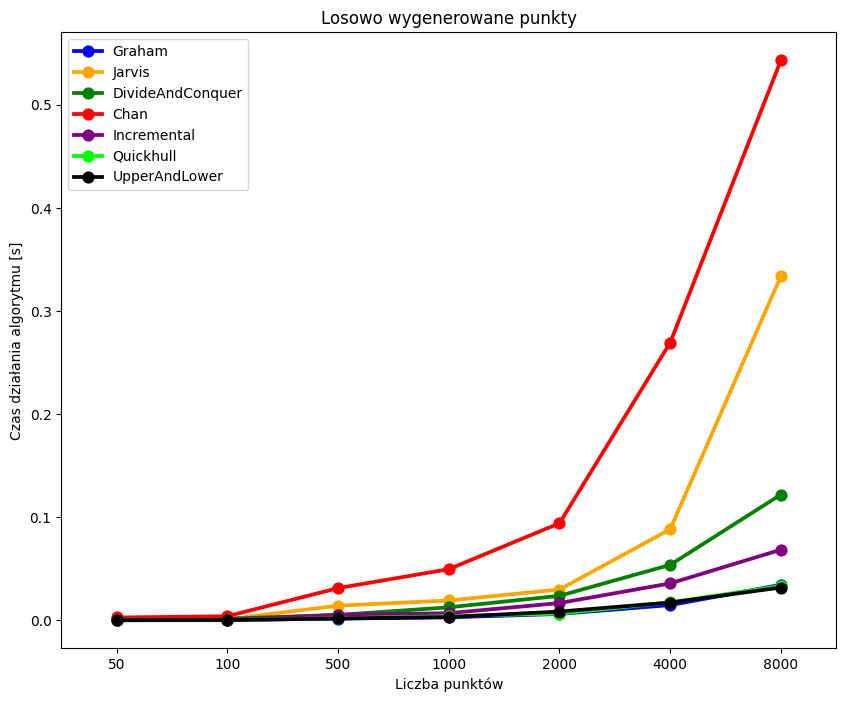

In [30]:
plt.figure(figsize=(10, 8))
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='Graham', label='Graham', color='blue')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='Jarvis', label='Jarvis', color='orange')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='DivideAndConquer', label='DivideAndConquer', color='green')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='Chan', label='Chan', color='red')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='Incremental', label='Incremental', color='purple')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='Quickhull', label='Quickhull', color='lime')
sns.pointplot(data=time_comparison_df[0:7],x='Number of points',y='UpperAndLower', label='UpperAndLower', color='black')
plt.xlabel('Liczba punktów')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Losowo wygenerowane punkty')
plt.legend(loc="best")

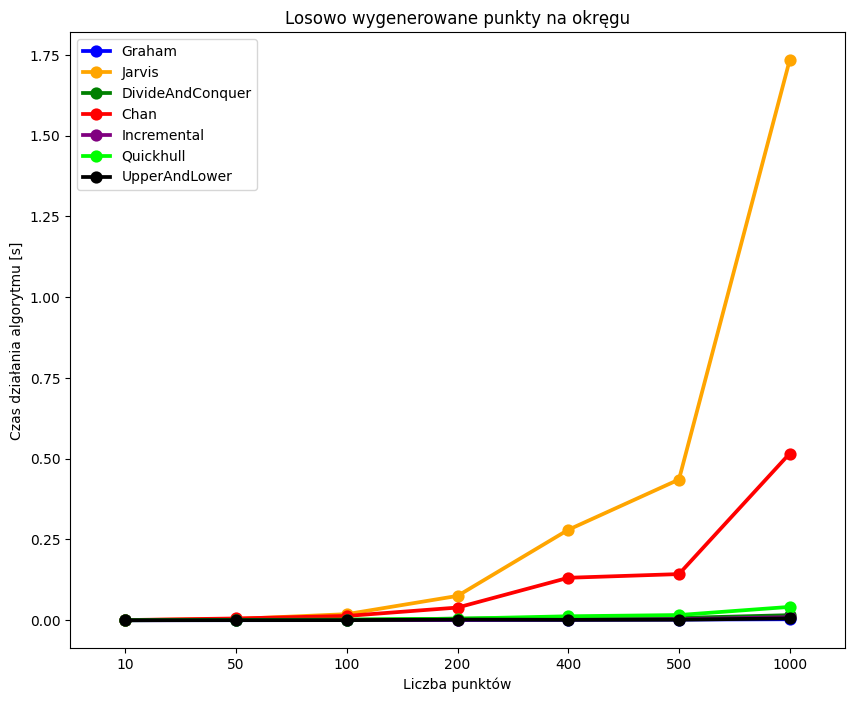

In [31]:
plt.figure(figsize=(10, 8))
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='Graham', label='Graham', color='blue')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='Jarvis', label='Jarvis', color='orange')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='DivideAndConquer', label='DivideAndConquer', color='green')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='Chan', label='Chan', color='red')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='Incremental', label='Incremental', color='purple')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='Quickhull', label='Quickhull', color='lime')
sns.pointplot(data=time_comparison_df[7:14],x='Number of points',y='UpperAndLower', label='UpperAndLower', color='black')
plt.xlabel('Liczba punktów')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Losowo wygenerowane punkty na okręgu')
plt.legend(loc="best")

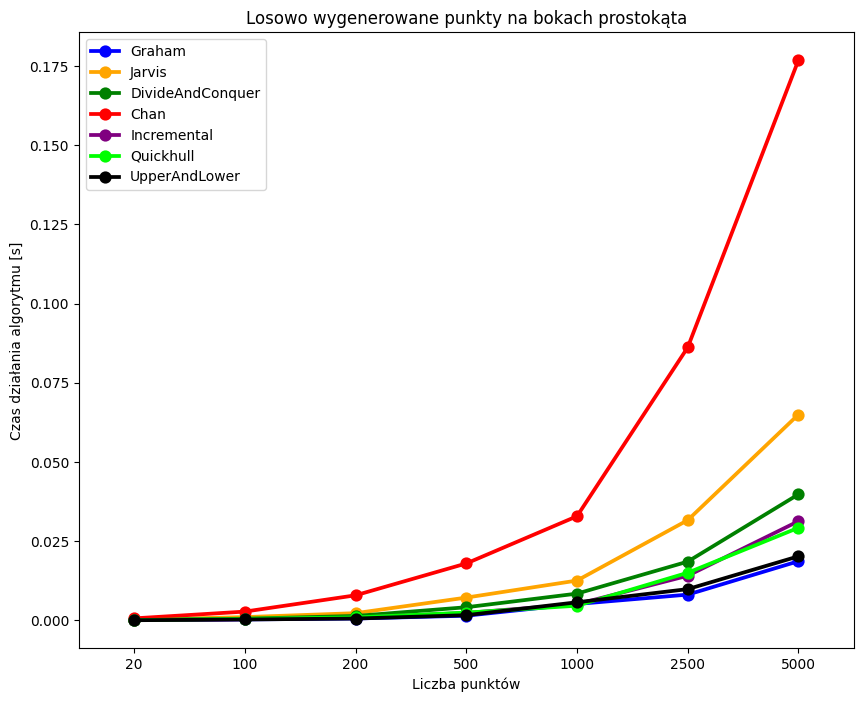

In [32]:
plt.figure(figsize=(10, 8))
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='Graham', label='Graham', color='blue')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='Jarvis', label='Jarvis', color='orange')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='DivideAndConquer', label='DivideAndConquer', color='green')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='Chan', label='Chan', color='red')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='Incremental', label='Incremental', color='purple')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='Quickhull', label='Quickhull', color='lime')
sns.pointplot(data=time_comparison_df[14:21],x='Number of points',y='UpperAndLower', label='UpperAndLower', color='black')
plt.xlabel('Liczba punktów')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Losowo wygenerowane punkty na bokach prostokąta')
plt.legend(loc="best")

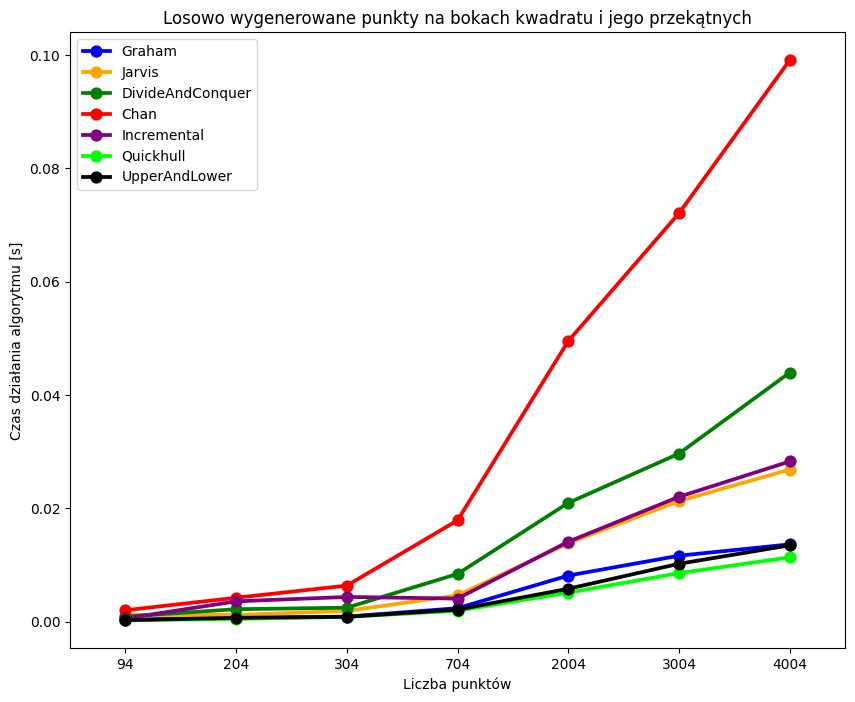

In [33]:
plt.figure(figsize=(10, 8))
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='Graham', label='Graham', color='blue')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='Jarvis', label='Jarvis', color='orange')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='DivideAndConquer', label='DivideAndConquer', color='green')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='Chan', label='Chan', color='red')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='Incremental', label='Incremental', color='purple')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='Quickhull', label='Quickhull', color='lime')
sns.pointplot(data=time_comparison_df[21:28],x='Number of points',y='UpperAndLower', label='UpperAndLower', color='black')
plt.xlabel('Liczba punktów')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Losowo wygenerowane punkty na bokach kwadratu i jego przekątnych')
plt.legend(loc="best")